# GMAC Optimization: Grid search of GMAC parameters

The GMAC algorithm has the following parameters required to map the raw acceleration
data to the arm-use space. These parameters are:
1. Moving average window size for pitch estimation. $\left( n_{p} \right)$
2. Butteworth highpass filter cut-off for accl. mag. estimation. $\left( f_{c} \right)$
3. Butteworth highpass filter order for accl. mag. estimation. $\left( n_{c} \right)$
4. Acceleration deadband threshold. $\left( a_{th0} \right)$
5. Moving average window for acceleration magnitude estimation. $\left( n_{am} \right)$
6. Pitch angle threshold. $\left( \theta_{th} \right)$
7. Acceleration magnitude threshold. $\left( a_{th} \right)$

## GMAC Algorithm

The GMAC algorithm is a combination of the gross movement (GM) algorithm and the 
activty counting (AC) algorithm. The GMAC algorithm, using only the accelerometer, 
tries to: (1) estimate the information used by GM and AC, forearm pitch angle and 
activity counts, respectively; and (2) applies thresholds on the estimated pitch 
and activity counting to estimate of the arm-use.

### Pitch Estimation
Pitch estimation is using the accelerometer data, and requies one to know the axis 
of accelerometer that is aligned with the forearm. The pitch is then estimated by 
estimating the arc-cosine of component of acceleration along this direction normalised 
by the magnitude of the acceleration due to gravity.

### Activity Counting Estimation
The activity counts is likely to be correlated to the magnitude of the highpass 
filtered acceleration.

### Applying thresholds
The pitch and activity counts are then thresholded to estimate the arm-use. 
Instead of applying a simple threshold algorithm that can be very sensitive to 
noise whenn the variable is close to the threshold, a simple thresholding is 
used for both the pitch and the acceleration magnitude variables.

### Parameter search ranges
$F_s$ is the sampling frequency of the accelerometer data.
1. $n_{p} \in \left\{1, F_s/2, F_s, 2F_s, 5F_s\right\}$
2. $f_{c} \in [0.01, 0.1, 1]Hz \subset \mathbb{R}$
3. $n_{c} \in \left\{ 2, 4, 8\right\}$
4. $n_{am} \in \left\{1, F_s/2, F_s, 2F_s, 5F_s\right\}$
5. $a_{th0} \in \left\{ 0, 0.068, 0.68\right\}$
6. $\theta_{th} \in \left\{ -90, -80, \ldots +90 \right\}\deg$
7. $a_{th} \in \left\{0, 5, 10, 50, 100\right\}$

### Getting the data

If you do not already have the data to run this this notebook, you need to
download it from here.



### Standards modules

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy
from scipy import signal
import pathlib
import itertools
import glob

In [3]:
import seaborn as sns

### Custom Modules

In [4]:
sys.path.append("../scripts")

import classification_algorithms as ca
import reduced_models as rm
import task_analysis as ta

import misc

## Define notebook level constants

In [5]:
# Sampling rate for the data is 50ms
dT = 0.02
Fs = int(1 / dT)

## Read the Controls and Patients Data

In [6]:
# Read healthy and control data
left, right = misc.read_data(subject_type='control')
aff, unaff = misc.read_data(subject_type='patient')

# Assign segments for each subject
left = pd.concat([misc.assign_segments(left[left.subject == subj], dur_th=1, dT=dT)
                  for subj in left.subject.unique()], axis=0)
right = pd.concat([misc.assign_segments(right[right.subject == subj], dur_th=1, dT=dT)
                   for subj in right.subject.unique()])
aff = pd.concat([misc.assign_segments(aff[aff.subject == subj], dur_th=1, dT=dT)
                 for subj in aff.subject.unique()])
unaff = pd.concat([misc.assign_segments(unaff[unaff.subject == subj], dur_th=1, dT=dT)
                   for subj in unaff.subject.unique()])

# All limbs data ddf
datadf = {
    "left": left,
    "right": right,
    "aff": aff,
    "unaff": unaff
}

### Functions implementing the GMAC algorithm

In [7]:
def estimate_pitch(accl_farm: np.array, nwin: int) -> np.array:
    """
    Estimates the pitch angle of the forearm from the accelerometer data.
    """
    # Moving averaging using the causal filter
    acclf = signal.lfilter(np.ones(nwin) / nwin, 1, accl_farm) if nwin > 1 else accl_farm
    acclf[acclf < -1] = -1
    acclf[acclf > 1] = 1        
    return -np.rad2deg(np.arccos(acclf)) + 90


def estimate_accl_mag(accl: np.array, fs: float, fc: float, nc: int,
                      deadband_th: float, n_am: int) -> np.array:
    """
    Compute the magnitude of the accelerometer signal.
    """
    # Highpass filter the acceleration data.
    sos = signal.butter(nc, fc, btype='highpass', fs=fs, output='sos')
    accl_filt = np.array([signal.sosfilt(sos, accl[:, 0]),
                          signal.sosfilt(sos, accl[:, 1]),
                          signal.sosfilt(sos, accl[:, 2])]).T
    
    # Zero load acceleration components.
    accl_filt[np.abs(accl_filt) < deadband_th] = 0
    
    # Acceleration magnitude    
    amag = np.linalg.norm(accl_filt, axis=1)
    
    # Moving average filter
    _input = np.append(np.ones(n_am - 1) * amag[0], amag)
    _impresp = np.ones(n_am) / n_am
    return np.convolve(_input, _impresp, mode='valid')

In [8]:
# Generate all possible combinations of parameters.
def generate_param_combinations(param_ranges: dict) -> dict:
    """
    Generate all possible combinations of parameters.
    """
    for _np in param_ranges["np"]:
        for _fc in param_ranges["fc"]:
            for _nc in param_ranges["nc"]:
                for _dbth in param_ranges["deadband_th"]:
                    for _nam in param_ranges["nam"]:
                        for _pth in param_ranges["p_th"]:
                            for _amth in param_ranges["am_th"]:
                                yield {
                                    "np": int(_np),
                                    "fc": _fc,
                                    "nc": int(_nc),
                                    "deadband_th": _dbth,
                                    "nam": int(_nam),
                                    "p_th": _pth,
                                    "am_th": _amth
                                }

In [10]:
def estimate_gmac(accl: np.array, accl_farm_inx: int, Fs: float, params: dict) -> np.array:
    """
    Estimate GMAC for the given acceleration data and parameters.
    """
    # Estimate pitch and acceleration magnitude
    pitch = estimate_pitch(accl[:, accl_farm_inx], params["np"])
    accl_mag = estimate_accl_mag(accl, Fs, fc=params["fc"], nc=params["nc"],
                                 deadband_th=params["deadband_th"],
                                 n_am=params["nam"])
    
    # Compute GMAC
    _pout = 1.0 * (pitch >= params["p_th"])
    _amout = 1.0 * (accl_mag >= params["am_th"])
    return _pout * _amout

In [11]:
def compute_confusion_matrix(actual: np.array, estimated: np.array) -> np.array:
    """
    Computes the components of the confusion matrix.
    """
    actual = np.array(actual, dtype=int)
    estimated = np.array(estimated, dtype=int)
    return {
        "TN": np.sum((actual + estimated) == 0), # TN
        "FP": np.sum((1 - actual + estimated) == 2), # FP
        "FN": np.sum((actual + 1 - estimated) == 2), # FN
        "TP": np.sum((actual + estimated) == 2), # TP
    }

#### Parameter ranges for the grid search

In [13]:
outdir = "../data/output-single-threshold"
limbkey = "unaff"
# Make directory if it does not exist
pathlib.Path(outdir, limbkey).mkdir(parents=True, exist_ok=True)

# GMAC Parameter ranges
gmac_param_ranges = {
    "np": [1, Fs, 5*Fs],
    "fc": [0.01, 0.1, 1],
    "nc": [2, 4],
    "deadband_th": [0, 0.068, 0.68],
    "nam": [1, Fs, 5*Fs],
    "p_th": np.arange(-90, 90, 10),
    "am_th": [0, 1, 5, 10]
}

# Number of all possible combinations
Ncombs = len(list(generate_param_combinations(gmac_param_ranges)))

# All parameter combinations.
param_combs = list(generate_param_combinations(gmac_param_ranges))


In [17]:
# Which limb?
limbdf = datadf[limbkey]
subjects = limbdf.subject.unique()

# All param combinations.
init_df = lambda : pd.DataFrame(columns=["subject", "pcinx",
                                   "np", "fc", "nc", "deadband_th", "nam",
                                   "p_thmin", "p_thmax",
                                   "am_thmin", "am_thmax",
                                   "TN", "FP", "FN", "TP"])
analysisdf = init_df()

nrows_write = 1000

# Check if any files exist
_files = glob.glob(pathlib.Path(outdir, limbkey, f"analysisdf-*.csv").as_posix())
if len(_files) == 0:
    nrow_max = 0
else:
    nrow_max = np.max([int(_f.split(".csv")[0].split("-")[-1])
                    for _f in _files])
# Written file name
_wrtnfile = ''
_wrtnrows = 0
for i1, _pc in enumerate(generate_param_combinations(gmac_param_ranges)):
    # Check if data already exists
    if i1 // nrows_write < nrow_max:
        continue
    # All subjects
    for i2, _subj in enumerate(subjects):
        _sinx= limbdf.subject == _subj
        # All segments
        segs = limbdf[_sinx].segment.unique()
        _gmacs = []
        for i3, _seg in enumerate(segs):
            sys.stdout.write(f"\r[{limbkey}] [Wrote: ({_wrtnfile})({_wrtnrows})] Combination: {i1+1:8d}/{Ncombs:6d}; {i2+1:3d}/{len(subjects):3d}; {i3+1:2d}/{len(segs):2d}")
            sys.stdout.flush()
            _ainx = _sinx & (limbdf.segment == _seg)
            # Estimate GMAC
            _accl = limbdf.loc[_ainx, ['ax', 'ay', 'az']].values
            _gmacs.append(estimate_gmac(_accl, 0, Fs, _pc))
        
        # Estimate confusion matrix components
        _perf = compute_confusion_matrix(actual=limbdf.loc[_sinx, "gnd"].values,
                                         estimated=np.hstack(_gmacs))
        # Update analysis DF
        _rowdf = pd.DataFrame({"subject": _subj, "pcinx": i1} | _pc | _perf, index=[0])
        analysisdf = pd.concat([analysisdf,_rowdf],
                               axis=0, ignore_index=True)
    # Save data regularly
    if i1 > 0 and i1 % nrows_write == 0:
        _wrtnfile = f"analysisdf-{(i1 // nrows_write) - 1}.csv"
        _wrtnrows = len(analysisdf)
        analysisdf.to_csv(pathlib.Path(outdir, limbkey, _wrtnfile).as_posix(), index=False)
        analysisdf = init_df()

# Save whatever is left
_wrtnfile = f"analysisdf-{(i1 // nrows_write)}.csv"
_wrtnrows = len(analysisdf)
sys.stdout.write(f"\r[{limbkey}] [Wrote: ({_wrtnfile})({_wrtnrows})] Combination: {i1+1:8d}/{Ncombs:6d}; {i2+1:3d}/{len(subjects):3d}; {i3+1:2d}/{len(segs):2d}")
analysisdf.to_csv(pathlib.Path(outdir, limbkey, f"analysisdf-{(i1 // nrows_write)}.csv"), index=False)

[unaff] [Wrote: (analysisdf-11.csv)(3315)] Combination:    11664/ 11664;   5/  5;  4/ 4

## Find the most appropriate paramters

In [20]:
def performance(yjvals: np.array) -> dict:
    """
    Computes the performance of the given GMAC.
    """
    if len(yjvals) == 0:
        return {
            "median": np.nan,
            "q5": np.nan,
            "q95": np.nan,
            "s90": np.nan,
            "perf": np.nan
        }
    q5, q50, q95 = np.percentile(yjvals, q=[5, 50, 95])
    return {
        "median": q50,
        "q5": q5,
        "q95": q95,
        "s90": q95 - q5,
        "perf": np.abs(q50 - 1) + 0.5 * (q95 - q5)
    }

In [21]:
def get_param_comb_difference(x1: np.array, x2: np.array) -> np.array:
    """Returns a custom distanc measure between two parameter combinations.
    """
    inx_cols = ["np", "fc", "nc", "deadband_th", "nam",
                "p_th", "p_th", "am_th", "am_th"]
    get_diff = lambda x, y, col: (np.where(gmac_param_ranges[col] == x)[0][0] -
                                  np.where(gmac_param_ranges[col] == y)[0][0])
    return np.linalg.norm([get_diff(*v) for v in zip(x1, x2, inx_cols)], ord=1)

---
## With testing data

In [32]:
limbkey = "unaff"
# Read all data and combine into a sigle DF
files = glob.glob(pathlib.Path(outdir, limbkey, "analysisdf*.csv").as_posix())
allanalysisdf = pd.read_csv(files[0], index_col=False)
for _f in files[1:]:
    _df = pd.read_csv(_f, index_col=False)
    allanalysisdf = pd.concat([allanalysisdf, _df], axis=0, ignore_index=True)
allanalysisdf

,subject,pcinx,np,fc,nc,deadband_th,nam,p_thmin,p_thmax,am_thmin,am_thmax,TN,FP,FN,TP,p_th,am_th
0,1,6001,50,0.1,4,0.00,250,NaN,NaN,NaN,NaN,4326,112,8371,17,-30.0,1.0
1,2,6001,50,0.1,4,0.00,250,NaN,NaN,NaN,NaN,6510,26,32093,176,-30.0,1.0
2,3,6001,50,0.1,4,0.00,250,NaN,NaN,NaN,NaN,6609,18,13296,11,-30.0,1.0
3,4,6001,50,0.1,4,0.00,250,NaN,NaN,NaN,NaN,7044,0,4237,0,-30.0,1.0
4,5,6001,50,0.1,4,0.00,250,NaN,NaN,NaN,NaN,9272,55,15134,0,-30.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58315,1,11663,250,1.0,4,0.68,250,NaN,NaN,NaN,NaN,4438,0,8388,0,80.0,10.0
58316,2,11663,250,1.0,4,0.68,250,NaN,NaN,NaN,NaN,6536,0,32269,0,80.0,10.0
58317,3,11663,250,1.0,4,0.68,250,NaN,NaN,NaN,NaN,6627,0,13307,0,80.0,10.0
58318,4,11663,250,1.0,4,0.68,250,NaN,NaN,NaN,NaN,7044,0,4237,0,80.0,10.0


In [33]:
# Compute different performance metrics
# Sensitivity
allanalysisdf["sensitivity"] = allanalysisdf.TP / (allanalysisdf.TP + allanalysisdf.FN)
# Specificity
allanalysisdf["specificity"] = allanalysisdf.TN / (allanalysisdf.TN + allanalysisdf.FP)
# Youden's J
allanalysisdf["youden"] = allanalysisdf.sensitivity + allanalysisdf.specificity - 1

# Save analysis DF
allanalysisdf.to_csv(pathlib.Path(outdir, limbkey, "allanalysisdf.csv"), index=False)

In [34]:
# Subjects
subjs = np.sort(allanalysisdf.subject.unique())
q = 95

# Optimization data frame
optdf = pd.DataFrame(columns=["pcinx", "median", "q95", "q5", "s90", "cost", "testval", "testsubj"])
for _nc in range(Ncombs):
    for sinx in range(len(subjs)):
        sys.stdout.write(f"\rCombination: {_nc+1:8d}/{Ncombs:6d}; {sinx+1:3d}/{len(subjs):3d}")
        sys.stdout.flush()
        testsubj = subjs[sinx]
        trainsubj = subjs[~(subjs == testsubj)]
        
        # Find the best parameter combination for the training subjects.
        _subjtraininx = allanalysisdf.subject.isin(trainsubj)
        _subjtestinx = allanalysisdf.subject == testsubj
        _inxtrain = allanalysisdf.pcinx == _nc
        _inxtest = allanalysisdf.pcinx == _nc
        
        # Find the best parameter combination for the training subjects.
        _yitrain = allanalysisdf.loc[_subjtraininx & _inxtrain, "youden"]
        _yitest = allanalysisdf.loc[_subjtestinx & _inxtest, "youden"]
        
        # Performance vairables.
        _perf = performance(_yitrain.values)
        _perfdf = pd.DataFrame({
            "pcinx": _nc,
            "median": _perf["median"],
            "q95": _perf["q95"],
            "q5": _perf["q5"],
            "s90": _perf["s90"],
            "cost": _perf["perf"],
            "testval": _yitest.values,
            "testsubj": testsubj
        })
        optdf = pd.concat([optdf, _perfdf], ignore_index=True)

# Save the optimization data frame        
optdf.to_csv(pathlib.Path(outdir, limbkey, f"optdf.csv"), index=False)

Combination:        2/ 11664;   3/  5

Combination:    11664/ 11664;   5/  5

In [38]:
limbkey = "unaff"
optdf = pd.read_csv(pathlib.Path(outdir, limbkey, f"optdf.csv"), index_col=False)

# Go through each validation subject, and choose the best training cost 
# parameter combination.
bestparamsdf = pd.DataFrame(columns=["subj", "lbound", "bestpinx", "bestval"])
for _subj in optdf.testsubj.unique():
    # _minval = np.min(optdf.loc[optdf.testsubj == _subj, "cost"])
    _sinx = optdf.testsubj == _subj
    _lbound = np.percentile(optdf.loc[optdf.testsubj == _subj, "cost"], 0.01)
    _bpins = list(np.where(optdf.loc[_sinx, "cost"] <= _lbound)[0])
    _bval = list(optdf.loc[_sinx, "testval"].values[_bpins])
    bestparamsdf = pd.concat([bestparamsdf, 
                              pd.DataFrame({"subj": [_subj] * len(_bpins),
                                            "lbound": [_lbound] * len(_bpins),
                                            "bestpinx": _bpins,
                                            "bestval": _bval})],
                             ignore_index=True)
# Save the optimization data frame
bestparamsdf.to_csv(pathlib.Path(outdir, limbkey, f"bestparamsdf.csv"), index=False)

## Choosing the best parameters

In [39]:
# Read the optimization data frame for the two limbs for healthy controls and
# stroke subjects
allanalysisdf = {
    "left": pd.read_csv(pathlib.Path(outdir, "left", f"allanalysisdf.csv"), index_col=False),
    "right": pd.read_csv(pathlib.Path(outdir, "right", f"allanalysisdf.csv"), index_col=False),
    "aff": pd.read_csv(pathlib.Path(outdir, "aff", f"allanalysisdf.csv"), index_col=False),
    "unaff": pd.read_csv(pathlib.Path(outdir, "unaff", f"allanalysisdf.csv"), index_col=False),
}

optdf = {
    "left": pd.read_csv(pathlib.Path(outdir, "left", f"optdf.csv"), index_col=False),
    "right": pd.read_csv(pathlib.Path(outdir, "right", f"optdf.csv"), index_col=False),
    "aff": pd.read_csv(pathlib.Path(outdir, "aff", f"optdf.csv"), index_col=False),
    "unaff": pd.read_csv(pathlib.Path(outdir, "unaff", f"optdf.csv"), index_col=False),
}

bestparamsdf = {
    "left": pd.read_csv(pathlib.Path(outdir, "left", f"bestparamsdf.csv"), index_col=False),
    "right": pd.read_csv(pathlib.Path(outdir, "right", f"bestparamsdf.csv"), index_col=False),
    "aff": pd.read_csv(pathlib.Path(outdir, "aff", f"bestparamsdf.csv"), index_col=False),
    "unaff": pd.read_csv(pathlib.Path(outdir, "unaff", f"bestparamsdf.csv"), index_col=False),
}

In [41]:
# Best parameters
bpc = pd.DataFrame(columns=["limb", "subj", "np", "fc", "nc", "deadband_th", "nam", "p_th", "am_th", "pcinx"])
for lkey in ["left", "right", "aff", "unaff"]:
    for ns in bestparamsdf[lkey]['subj'].unique():
        ns_inx = bestparamsdf[lkey]['subj'] == ns
        bpc_inx = bestparamsdf[lkey].loc[ns_inx, "bestpinx"].values
        bpc_vals_df = pd.DataFrame.from_dict([param_combs[_inx] for _inx in bpc_inx])
        bpc = pd.concat([
            bpc,
            pd.DataFrame.from_dict({
                "limb": [lkey], "subj": [ns],
                "np": [bpc_vals_df.np.value_counts().index[0]],
                "fc": [float(bpc_vals_df.loc[:, ["fc", "nc"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts().index[0].split(":")[0])],
                "nc": [int(float(bpc_vals_df.loc[:, ["fc", "nc"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts().index[0].split(":")[1]))],
                "deadband_th": [bpc_vals_df.deadband_th.value_counts().index[0]],
                "nam": [bpc_vals_df.nam.value_counts().index[0]],
                "p_th": [int(bpc_vals_df.p_th.value_counts().index[0])],
                "am_th": [int(bpc_vals_df.am_th.value_counts().index[0])]
            })
        ], axis=0, ignore_index=True)
bpc

,limb,subj,np,fc,nc,deadband_th,nam,p_th,am_th,pcinx
0,left,1,50,0.01,2,0.0,1,-10,0,NaN
1,left,2,50,0.01,2,0.0,1,-10,0,NaN
2,left,3,50,0.01,2,0.0,1,-10,0,NaN
3,left,4,50,0.01,2,0.0,1,-10,0,NaN
4,left,5,50,0.01,2,0.0,1,-10,0,NaN
5,left,6,250,0.01,2,0.0,1,-10,0,NaN
6,left,7,50,0.01,2,0.0,1,-10,0,NaN
7,left,8,50,0.01,2,0.0,1,-10,0,NaN
8,left,9,250,0.01,2,0.0,1,-10,0,NaN
9,left,10,50,0.01,2,0.0,1,-10,0,NaN


In [42]:
param_cols = [_c for _c in bpc.columns if _c not in ['subj', 'limb', 'pcinx', 'youden']]
pcarray = pd.DataFrame.from_dict(param_combs).to_numpy()
for i in bpc.index:
    lkey = bpc.loc[i, 'limb']
    bpc.loc[i, 'pcinx'] = int(np.where(np.all(pcarray == bpc.loc[i, param_cols].to_numpy(), axis=1))[0][0])
    _sinx = allanalysisdf[lkey]['subject'] == bpc.loc[i, 'subj']
    _pinx = allanalysisdf[lkey]['pcinx'] == bpc.loc[i, 'pcinx']
    bpc.loc[i, 'youden'] = allanalysisdf[lkey].loc[_sinx & _pinx, 'youden'].values[0]
bpc

,limb,subj,np,fc,nc,deadband_th,nam,p_th,am_th,pcinx,youden
0,left,1,50,0.01,2,0.0,1,-10,0,3920,0.313027
1,left,2,50,0.01,2,0.0,1,-10,0,3920,0.261737
2,left,3,50,0.01,2,0.0,1,-10,0,3920,0.374485
3,left,4,50,0.01,2,0.0,1,-10,0,3920,0.398099
4,left,5,50,0.01,2,0.0,1,-10,0,3920,0.301634
5,left,6,250,0.01,2,0.0,1,-10,0,7808,0.442313
6,left,7,50,0.01,2,0.0,1,-10,0,3920,0.307130
7,left,8,50,0.01,2,0.0,1,-10,0,3920,0.323872
8,left,9,250,0.01,2,0.0,1,-10,0,7808,0.267351
9,left,10,50,0.01,2,0.0,1,-10,0,3920,0.346197


Text(0.5, 1.0, "Youden's index")

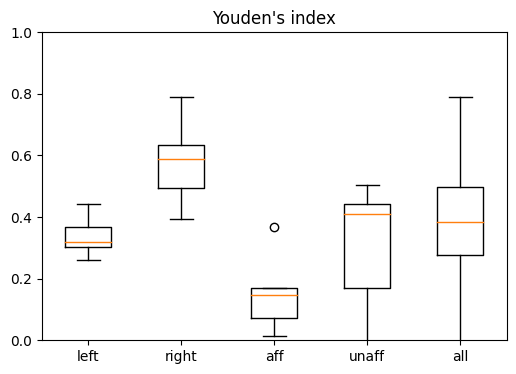

In [43]:
# Find out performance
yinx = []
for lkey in ["left", "right", "aff", "unaff"]:
    yinx.append([])
    for i in bpc.loc[bpc['limb'] == lkey, :].index:
        _sinx = allanalysisdf[lkey]['subject'] == bpc.loc[i, 'subj']
        _pinx = allanalysisdf[lkey]['pcinx'] == bpc.loc[i, 'pcinx']
        yinx[-1].append(allanalysisdf[lkey].loc[_sinx & _pinx, 'youden'].values[0])

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.boxplot(yinx + [[z for x in yinx for z in x]], notch=False,
           labels=["left", "right", "aff", "unaff", "all"])
ax.set_ylim(0.0, 1.0)
ax.set_title("Youden's index")

---
## Choose the Best model using all data

In [30]:
limbkey = "unaff"
# Read all data and combine into a sigle DF
files = glob.glob(pathlib.Path(outdir, limbkey, "analysisdf*.csv").as_posix())
allanalysisdf = pd.read_csv(files[0], index_col=False)
for _f in files[1:]:
    _df = pd.read_csv(_f, index_col=False)
    allanalysisdf = pd.concat([allanalysisdf, _df], axis=0, ignore_index=True)
allanalysisdf

,subject,pcinx,np,fc,nc,deadband_th,nam,p_thmin,p_thmax,am_thmin,am_thmax,TN,FP,FN,TP,p_th,am_th
0,1,6001,50,0.1,4,0.00,250,NaN,NaN,NaN,NaN,4326,112,8371,17,-30.0,1.0
1,2,6001,50,0.1,4,0.00,250,NaN,NaN,NaN,NaN,6510,26,32093,176,-30.0,1.0
2,3,6001,50,0.1,4,0.00,250,NaN,NaN,NaN,NaN,6609,18,13296,11,-30.0,1.0
3,4,6001,50,0.1,4,0.00,250,NaN,NaN,NaN,NaN,7044,0,4237,0,-30.0,1.0
4,5,6001,50,0.1,4,0.00,250,NaN,NaN,NaN,NaN,9272,55,15134,0,-30.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58315,1,11663,250,1.0,4,0.68,250,NaN,NaN,NaN,NaN,4438,0,8388,0,80.0,10.0
58316,2,11663,250,1.0,4,0.68,250,NaN,NaN,NaN,NaN,6536,0,32269,0,80.0,10.0
58317,3,11663,250,1.0,4,0.68,250,NaN,NaN,NaN,NaN,6627,0,13307,0,80.0,10.0
58318,4,11663,250,1.0,4,0.68,250,NaN,NaN,NaN,NaN,7044,0,4237,0,80.0,10.0


In [31]:
# Compute different performance metrics
# Sensitivity
allanalysisdf["sensitivity"] = allanalysisdf.TP / (allanalysisdf.TP + allanalysisdf.FN)
# Specificity
allanalysisdf["specificity"] = allanalysisdf.TN / (allanalysisdf.TN + allanalysisdf.FP)
# Youden's J
allanalysisdf["youden"] = allanalysisdf.sensitivity + allanalysisdf.specificity - 1

# Save analysis DF
allanalysisdf.to_csv(pathlib.Path(outdir, limbkey, "allanalysisdf.csv"), index=False)

In [32]:
# Subjects
subjs = np.sort(allanalysisdf.subject.unique())
q = 95

# Optimization data frame
optdf = pd.DataFrame(columns=["pcinx", "median", "q95", "q5", "s90", "cost"])
for _nc in range(Ncombs):
    sys.stdout.write(f"\rCombination: {_nc+1:8d}/{Ncombs:6d}")
    sys.stdout.flush()
    
    # Performance vairables.
    _perf = performance(allanalysisdf.loc[allanalysisdf.pcinx == _nc, "youden"].values)
    _perfdf = pd.DataFrame({
        "pcinx": _nc,
        "median": _perf["median"],
        "q95": _perf["q95"],
        "q5": _perf["q5"],
        "s90": _perf["s90"],
        "cost": _perf["perf"],
    }, index=[0])
    optdf = pd.concat([optdf, _perfdf], ignore_index=True)

# Save the optimization data frame        
optdf.to_csv(pathlib.Path(outdir, limbkey, f"optdf-notest.csv"), index=False)

Combination:    11664/ 11664

In [36]:
limbkey = "unaff"
optdf = pd.read_csv(pathlib.Path(outdir, limbkey, f"optdf-notest.csv"), index_col=False)

# Go through each validation subject, and choose the best training cost 
# parameter combination.
bestparamsdf = pd.DataFrame(columns=["lbound", "bestpinx"])
_lbound = np.nanpercentile(optdf.loc[:, "cost"], 0.01)
_bpins = list(np.where(optdf.loc[:, "cost"] <= _lbound)[0])
bestparamsdf = pd.concat([bestparamsdf, 
                            pd.DataFrame({"lbound": [_lbound] * len(_bpins),
                                          "bestpinx": _bpins})],
                            ignore_index=True)
# Save the optimization data frame
bestparamsdf.to_csv(pathlib.Path(outdir, limbkey, f"bestparamsdf-notest.csv"), index=False)

---
# Choosing the optimal parameters for healthy and stroke subjects

In [39]:
# Read the optimization data frame for the two limbs for healthy controls and
# stroke subjects
allanalysisdf = {
    "left": pd.read_csv(pathlib.Path(outdir, "left", f"allanalysisdf.csv"), index_col=False),
    "right": pd.read_csv(pathlib.Path(outdir, "right", f"allanalysisdf.csv"), index_col=False),
    "aff": pd.read_csv(pathlib.Path(outdir, "aff", f"allanalysisdf.csv"), index_col=False),
    "unaff": pd.read_csv(pathlib.Path(outdir, "unaff", f"allanalysisdf.csv"), index_col=False),
}

optdf = {
    "left": pd.read_csv(pathlib.Path(outdir, "left", f"optdf-notest.csv"), index_col=False),
    "right": pd.read_csv(pathlib.Path(outdir, "right", f"optdf-notest.csv"), index_col=False),
    "aff": pd.read_csv(pathlib.Path(outdir, "aff", f"optdf-notest.csv"), index_col=False),
    "unaff": pd.read_csv(pathlib.Path(outdir, "unaff", f"optdf-notest.csv"), index_col=False),
}

bestparamsdf = {
    "left": pd.read_csv(pathlib.Path(outdir, "left", f"bestparamsdf-notest.csv"), index_col=False),
    "right": pd.read_csv(pathlib.Path(outdir, "right", f"bestparamsdf-notest.csv"), index_col=False),
    "aff": pd.read_csv(pathlib.Path(outdir, "aff", f"bestparamsdf-notest.csv"), index_col=False),
    "unaff": pd.read_csv(pathlib.Path(outdir, "unaff", f"bestparamsdf-notest.csv"), index_col=False),
}

# Dataframe of the best parameter combinations
best_pc_vals_df = {
    "left": pd.DataFrame.from_dict([param_combs[_inx] for _inx in bestparamsdf["left"]["bestpinx"]]),
    "right": pd.DataFrame.from_dict([param_combs[_inx] for _inx in bestparamsdf["right"]["bestpinx"]]),
    "aff": pd.DataFrame.from_dict([param_combs[_inx] for _inx in bestparamsdf["aff"]["bestpinx"]]),
    "unaff": pd.DataFrame.from_dict([param_combs[_inx] for _inx in bestparamsdf["unaff"]["bestpinx"]]),
}

In [44]:
# Best parameters
bpc = pd.DataFrame(columns=["limb", "np", "fc", "nc", "deadband_th", "nam", "p_th", "am_th"])
for lkey in ["left", "right", "aff", "unaff"]:
    bpc_inx = bestparamsdf[lkey].loc[:, "bestpinx"].values
    bpc_vals_df = pd.DataFrame.from_dict([param_combs[_inx] for _inx in bpc_inx])
    bpc = pd.concat([
        bpc,
        pd.DataFrame.from_dict({
            "limb": [lkey],
            "np": [bpc_vals_df.np.value_counts().index[0]],
            "fc": [float(bpc_vals_df.loc[:, ["fc", "nc"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts().index[0].split(":")[0])],
            "nc": [int(float(bpc_vals_df.loc[:, ["fc", "nc"]].apply(lambda x: f"{x[0]}:{x[1]}", axis=1).value_counts().index[0].split(":")[1]))],
            "deadband_th": [bpc_vals_df.deadband_th.value_counts().index[0]],
            "nam": [bpc_vals_df.nam.value_counts().index[0]],
            "p_th": [int(bpc_vals_df.p_th.value_counts().index[0])],
            "am_th": [int(bpc_vals_df.am_th.value_counts().index[0])]
        })
    ], axis=0, ignore_index=True)
bpc

,limb,np,fc,nc,deadband_th,nam,p_th,am_th
0,left,50,0.01,2,0.0,1,-10,0
1,right,250,0.01,2,0.0,1,0,0
2,aff,50,0.01,2,0.0,1,20,0
3,unaff,250,0.01,2,0.0,1,0,0
